### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies

Install Keras and KerasNLP.

In [ ]:
# Install Keras and KerasHub
!pip install -q -U keras keras-hub

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_hub
import keras
# Run at half precision.
keras.config.set_floatx("bfloat16")

## Load Image

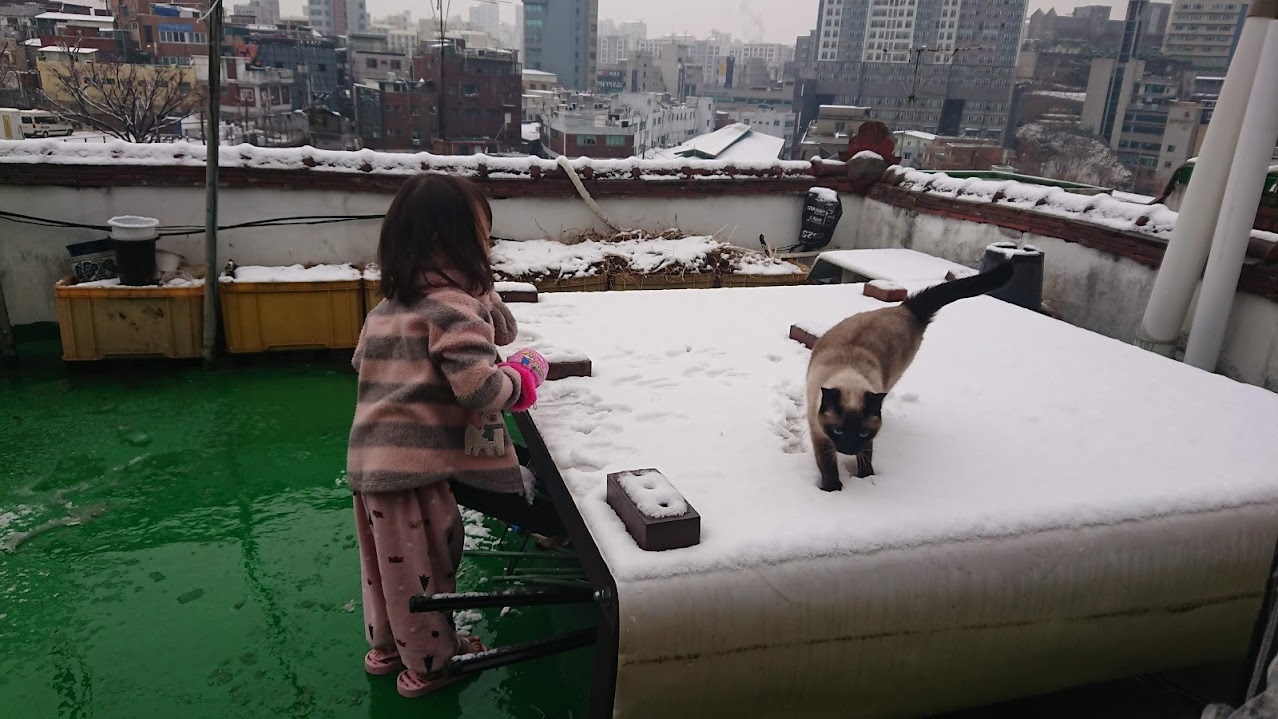

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from keras.utils import img_to_array
import requests

img_url = "https://github.com/bebechien/gemma/blob/main/PaliGemma_Demo.JPG?raw=true"
input_image = Image.open(requests.get(img_url, stream=True).raw)

from IPython.display import display
display(input_image)

###############################
# some helper functions below #
###############################
import cv2
import re

def draw_bounding_box(image, coordinates, label, label_colors, width, height):
    y1, x1, y2, x2 = coordinates
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
    text_width, text_height = text_size

    text_x = x1 + 2
    text_y = y1 - 5

    font_scale = 1
    label_rect_width = text_width + 8
    label_rect_height = int(text_height * font_scale)

    color = label_colors.get(label, None)
    if color is None:
        color = np.random.randint(0, 256, (3,)).tolist()
        label_colors[label] = color

    cv2.rectangle(image, (x1, y1 - label_rect_height), (x1 + label_rect_width, y1), color, -1)

    thickness = 2
    cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    return image

def draw_results(paligemma_response):
  detections = paligemma_response.split(" ; ")
  parsed_coordinates = []
  labels = []
  label_colors = {}
  output_image = input_image
  output_img = np.array(input_image)

  if len(detections) > 1:
    for item in detections:
      detection = item.replace("<loc", "").split()

      if len(detection) >= 2:
        coordinates_str = detection[0]
        coordinates = coordinates_str.split(">")
        coordinates = coordinates[:4]

        if coordinates[-1] == '':
          coordinates = coordinates[:-1]

        coordinates = [int(coord)/1024 for coord in coordinates]
        parsed_coordinates.append(coordinates)

        for label in detection[1:]:
          if "<seg" in label:
            continue
          else:
            labels.append(label)

      else:
        # No label detected, skip the iteration.
        continue

      width = input_image.size[0]
      height = input_image.size[1]

      # Draw bounding boxes on the frame.
      image = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)
      for coordinates, label in zip(parsed_coordinates, labels):
        output_img = draw_bounding_box(output_img, coordinates, label, label_colors, width, height)

      output_image = Image.fromarray(output_img)

  elif len(detections) == 1:
    for item in detections:
      detection = item.split("<loc")

      if len(detection) >= 5:
        coordinates = []
        for value in detection[1:5]:
          coordinates.append(value.split(">")[0])

        if coordinates[-1] == '':
          coordinates = coordinates[:-1]

        coordinates = [int(coord)/1024 for coord in coordinates]
        parsed_coordinates.append(coordinates)
        labels.append("object")

      else:
        # No label detected, skip the iteration.
        continue

      width = input_image.size[0]
      height = input_image.size[1]

      # Draw bounding boxes on the frame.
      image = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)
      for coordinates, label in zip(parsed_coordinates, labels):
        output_img = draw_bounding_box(output_img, coordinates, label, label_colors, width, height)

      output_image = Image.fromarray(output_img)

  return output_image

## Load Model

In [ ]:
model_name = "kaggle://keras/paligemma2/keras/pali_gemma_2_ft_docci_3b_448"

# we need to resize the image to the size expected by the model
# we're assuming the model name ends with _NUM here
target_size_x = int(model_name[model_name.rfind("_") + 1 :])
target_size = (target_size_x, target_size_x)

pali_gemma_lm = keras_hub.models.PaliGemmaCausalLM.from_preset(model_name)
pali_gemma_lm.summary()

100%|██████████| 1.06k/1.06k [00:00<00:00, 1.37MB/s]


100%|██████████| 5.65G/5.65G [01:56<00:00, 52.3MB/s]


100%|██████████| 431/431 [00:00<00:00, 280kB/s]


100%|██████████| 4.07M/4.07M [00:00<00:00, 9.33MB/s]


100%|██████████| 510/510 [00:00<00:00, 609kB/s]


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (448, 448) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 448, 448, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,979,696 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,979,696 (5.65 GB)

 Trainable params: 3,032,979,696 (5.65 GB)

 Non-trainable params: 0 (0.00 B)

## Inference

<image>caption en
A medium view of a girl and a cat on a rooftop. The girl is facing the right side and is looking at a brown cat that is standing on a white carpet that is covered in snow. The cat is looking at the girl, and its tail is sticking out to the right. The carpet is green, and the ground is also green. The girl is wearing a pink and gray striped sweater and pants. On the left side of the carpet, there is a yellow box that is filled with snow. Behind the cat and girl, there is a white wall that has a red brick border. On the other side of the wall, there are many buildings that are covered in snow.


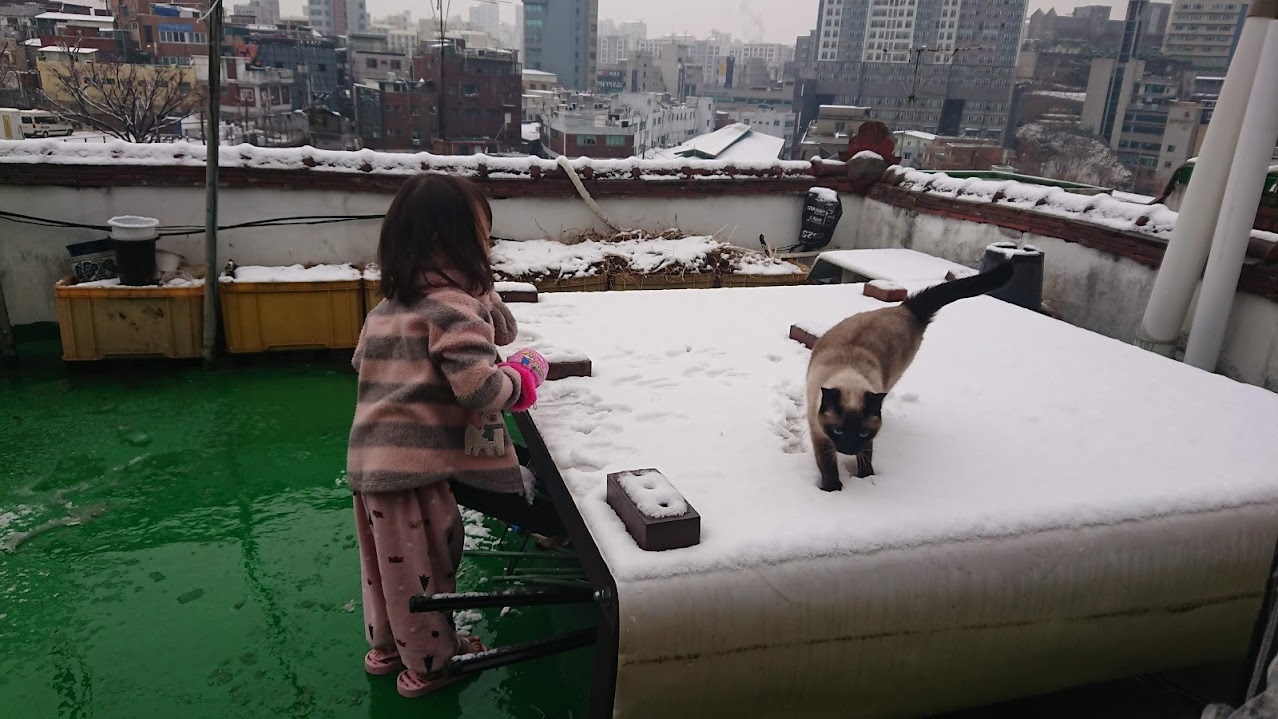

In [ ]:
########
input_text = "<image>caption en\n"
result = pali_gemma_lm.generate(
    inputs={
        "images": img_to_array(input_image.resize(target_size)),
        "prompts": input_text,
    }
)
print(result)

draw_results(result[len(input_text):])

detect  cat ; person
<loc0240><loc0277><loc0990><loc0435> <seg027><seg009><seg060><seg088><seg021><seg116><seg064><seg055><seg000><seg066><seg114><seg089><seg027><seg063><seg057><seg089> person ; <loc0362><loc0644><loc0699><loc0825> <seg114><seg041><seg037><seg121><seg029><seg073><seg060><seg089><seg051><seg117><seg074><seg012><seg044><seg116><seg057><seg012> cat


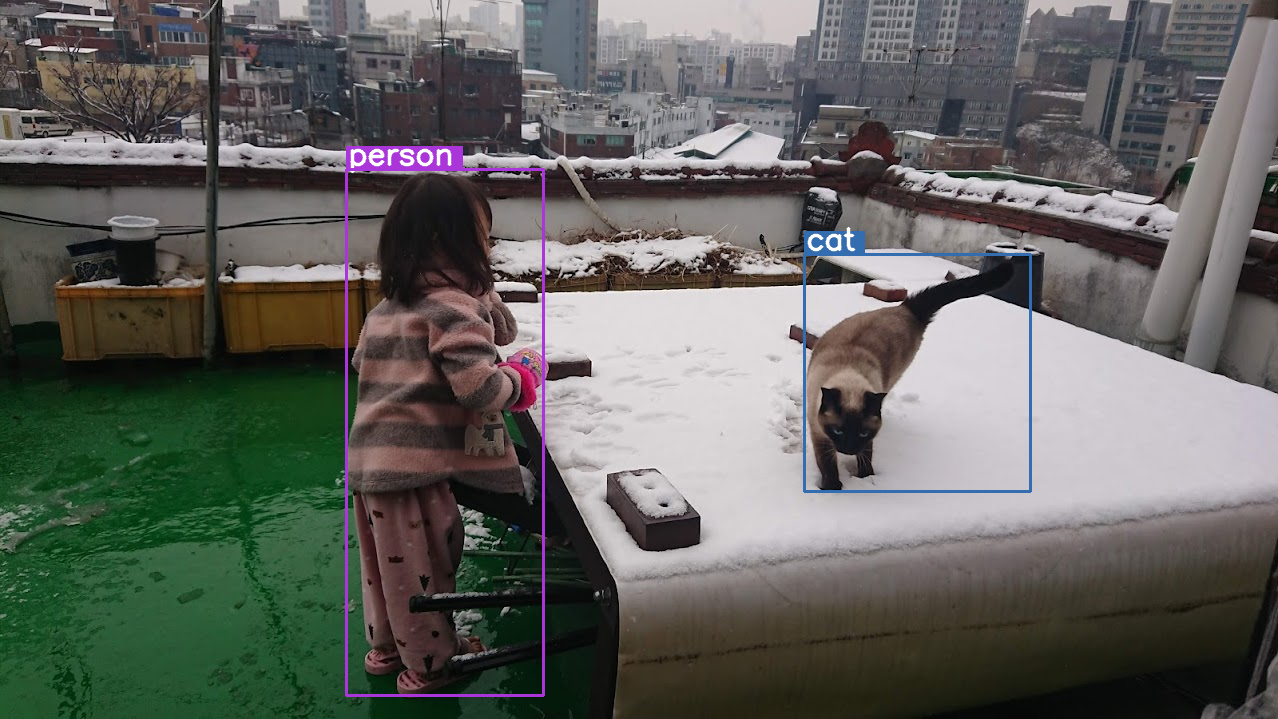

In [ ]:
########
input_text = "detect  cat ; person\n"
result = pali_gemma_lm.generate(
    inputs={
        "images": img_to_array(input_image.resize(target_size)),
        "prompts": input_text,
    }
)
print(result)

draw_results(result[len(input_text):])
